### **Extracción del Archivo Tratado**

In [1]:
import pandas as pd
import json

# Cargar el archivo JSON
with open('../TelecomX_Data.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)
print("DataFrame cargado exitosamente. Primeras 5 filas:")
print(df.head())
    


DataFrame cargado exitosamente. Primeras 5 filas:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes       

### **Eliminación de Columnas Irrelevantes**

In [2]:
df = df.drop(columns=['customerID'])
print("\nColumna 'customerID' eliminada. Columnas restantes:")
print(df.columns)


Columna 'customerID' eliminada. Columnas restantes:
Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total'],
      dtype='object')


### **Encoding**

In [3]:
# Identificar columnas categóricas (excluyendo 'Churn')
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'Churn' in categorical_cols:
  categorical_cols.remove('Churn')

# Aplicar one-hot encoding a las columnas categóricas
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nDataFrame después del encoding. Primeras 5 filas:")
print(df_encoded.head())
print("\nColumnas después del encoding:")
print(df_encoded.columns)
    


DataFrame después del encoding. Primeras 5 filas:
  Churn  customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
0    No                       0                9                     65.6   
1    No                       0                9                     59.9   
2   Yes                       0                4                     73.9   
3   Yes                       1               13                     98.0   
4   Yes                       1                3                     83.9   

   customer.gender_Male  customer.Partner_Yes  customer.Dependents_Yes  \
0                 False                  True                     True   
1                  True                 False                    False   
2                  True                 False                    False   
3                  True                  True                    False   
4                 False                  True                    False   

   phone.PhoneService_Yes  phone.Multiple

### **Verificación de la Proporción de Cancelación (Churn)**

In [4]:
churn_proportion = df_encoded['Churn'].value_counts(normalize=True)
print("\nProporción de la variable 'Churn':")
print(churn_proportion)

if churn_proportion['Yes'] < 0.3 or churn_proportion['No'] < 0.3:
  print("\nAdvertencia: Existe un desbalance significativo en la variable 'Churn'.")
    


Proporción de la variable 'Churn':
Churn
No     0.711986
Yes    0.257190
       0.030824
Name: proportion, dtype: float64

Advertencia: Existe un desbalance significativo en la variable 'Churn'.


### **Balanceo de Clases**

In [13]:
import pandas as pd
import json
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np # Importar numpy para np.nan

# --- 5. Balanceo de Clases ---
# Separar características (X) y la variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Asegurarse de que no queden columnas 'object' en X antes de SMOTE
# (Esto ya debería estar cubierto por el paso 3 y el pre-procesamiento de Total)
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Advertencia: La columna '{col}' sigue siendo de tipo 'object' antes de SMOTE. Se intentará codificar.")
        X = pd.get_dummies(X, columns=[col], drop_first=True)


# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nProporción de la variable 'Churn' después del balanceo con SMOTE:")
print(y_resampled.value_counts(normalize=True))    


Proporción de la variable 'Churn' después del balanceo con SMOTE:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


### **Normalización o Estandarización (si es necesario)**

In [14]:
# --- 6. Normalización o Estandarización (si es necesario) ---
# Identificar columnas numéricas para escalar
numeric_cols = X_resampled.select_dtypes(include=['int64', 'float64']).columns

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = X_resampled.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X_resampled[numeric_cols])

print("\nDataFrame después de la estandarización. Primeras 5 filas de las características escaladas:")
print(X_scaled.head())



DataFrame después de la estandarización. Primeras 5 filas de las características escaladas:
   customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
0               -0.395454        -0.775273                -0.087421   
1               -0.395454        -0.775273                -0.286039   
2               -0.395454        -0.984063                 0.201795   
3                2.528739        -0.608241                 1.041568   
4                2.528739        -1.025821                 0.550249   

   account.Charges.Total  customer.gender_Male  customer.Partner_Yes  \
0              -0.665026                 False                  True   
1              -0.688323                  True                 False   
2              -0.808032                  True                 False   
3              -0.370021                  True                  True   
4              -0.814188                 False                  True   

   customer.Dependents_Yes  phone.PhoneService_

### **Análisis de Correlación**

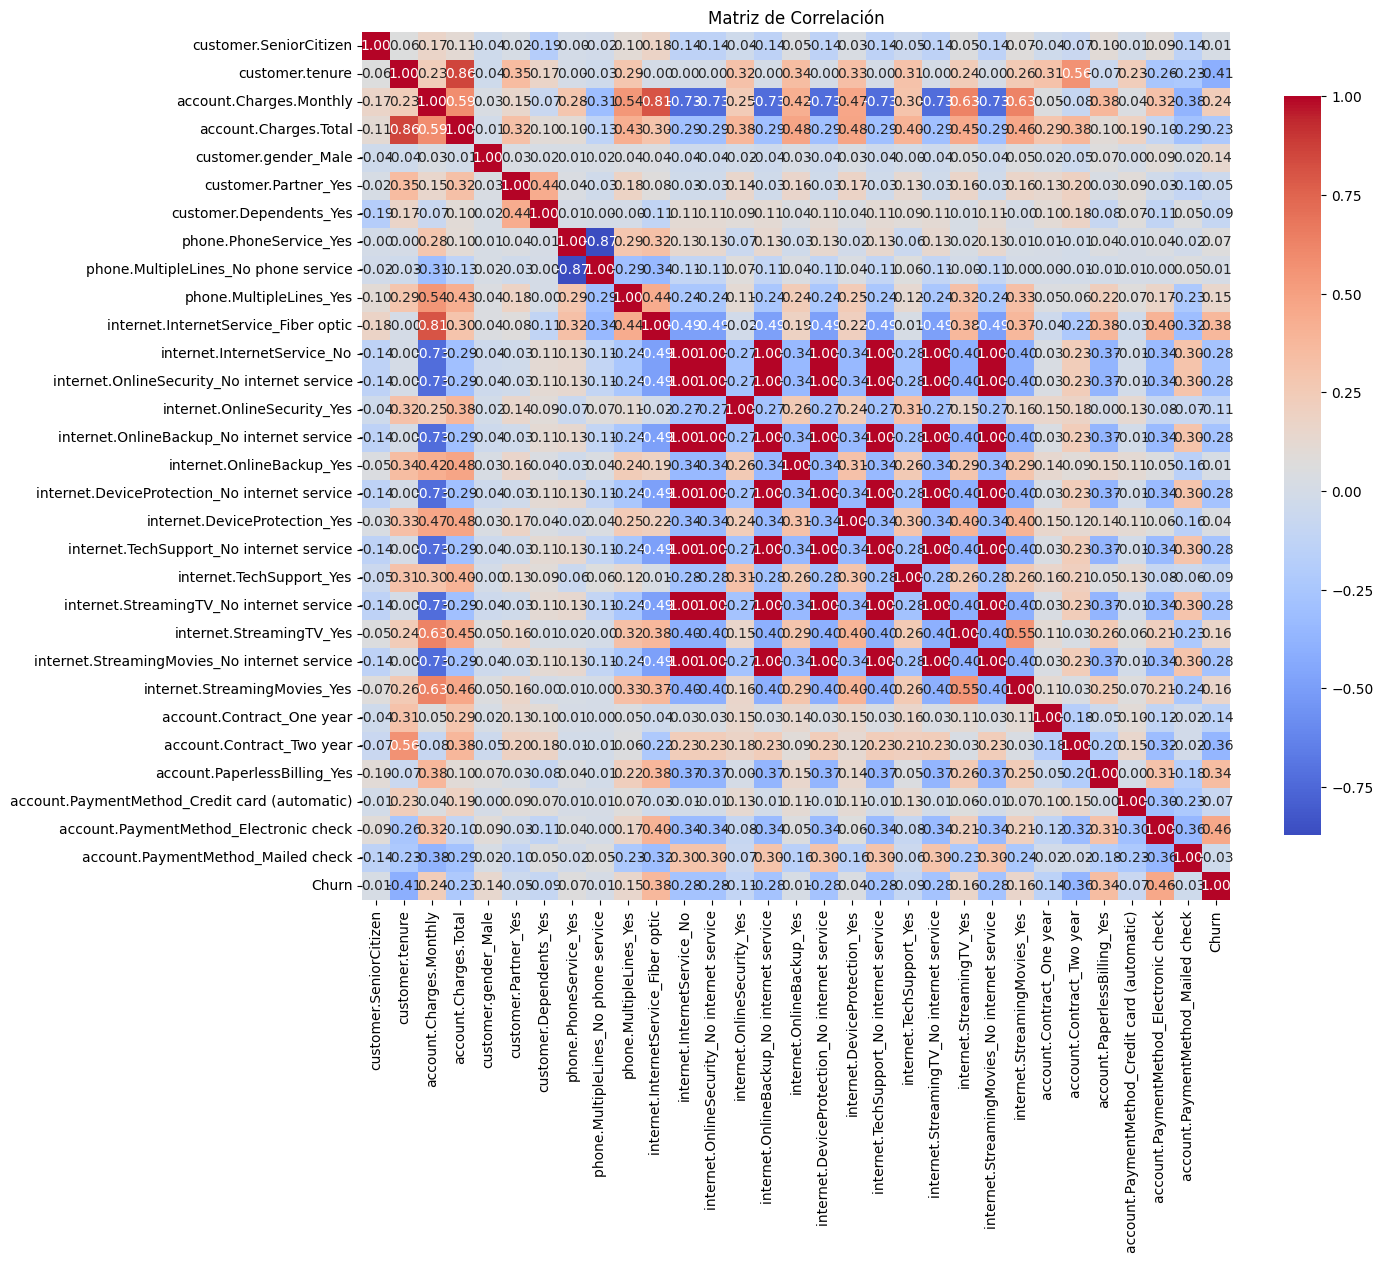


Correlaciones de las variables con 'Churn':
Churn                                            1.000000
account.PaymentMethod_Electronic check           0.459292
internet.InternetService_Fiber optic             0.375181
account.PaperlessBilling_Yes                     0.342796
account.Charges.Monthly                          0.235366
internet.StreamingTV_Yes                         0.164659
internet.StreamingMovies_Yes                     0.156463
phone.MultipleLines_Yes                          0.146984
customer.gender_Male                             0.141621
phone.PhoneService_Yes                           0.069420
internet.DeviceProtection_Yes                    0.035915
internet.OnlineBackup_Yes                        0.014930
customer.SeniorCitizen                           0.013001
phone.MultipleLines_No phone service             0.012180
account.PaymentMethod_Mailed check              -0.033538
customer.Partner_Yes                            -0.050945
account.PaymentMethod_Credi

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de que 'Churn' esté en el DataFrame para el análisis de correlación
# Reunir X_resampled y y_resampled en un solo DataFrame para el análisis
df_analysis = pd.DataFrame(X_resampled, columns=X.columns)
df_analysis['Churn'] = y_resampled

# Calcular la matriz de correlación
correlation_matrix = df_analysis.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

# Identificar correlaciones con la variable 'Churn'
churn_correlation = correlation_matrix['Churn']
print("\nCorrelaciones de las variables con 'Churn':")
print(churn_correlation.sort_values(ascending=False))


### **Análisis Dirigido**

La columna 'Contract' no está presente en el DataFrame.


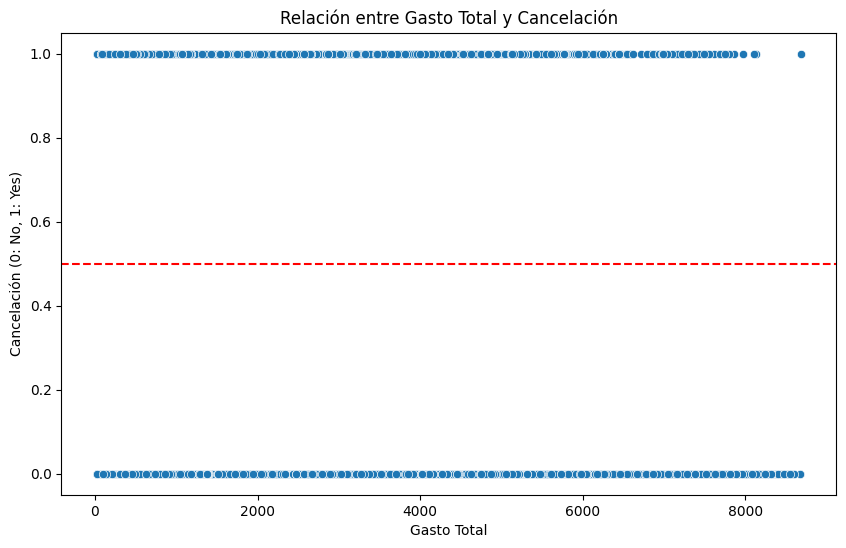

In [18]:
# --- Análisis Dirigido: Tiempo de Contrato × Cancelación ---
# Asegurarse de que la columna 'Contract' esté presente en el DataFrame original
if 'Contract' in df.columns:
    # Convertir 'Contract' a numérico para el análisis
    df['Contract'] = df['contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

    # Visualizar la relación entre el tiempo de contrato y la cancelación
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Contract', y='Churn', data=df)
    plt.title('Relación entre Tiempo de Contrato y Cancelación')
    plt.xlabel('Tiempo de Contrato (0: Month-to-month, 1: One year, 2: Two year)')
    plt.ylabel('Cancelación (0: No, 1: Yes)')
    plt.xticks([0, 1, 2], ['Month-to-month', 'One year', 'Two year'])
    plt.show()
else:
    print("La columna 'Contract' no está presente en el DataFrame.")

# --- Análisis Dirigido: Gasto Total × Cancelación ---
# Visualizar la relación entre el gasto total y la cancelación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='account.Charges.Total', y='Churn', data=df)
plt.title('Relación entre Gasto Total y Cancelación')
plt.xlabel('Gasto Total')
plt.ylabel('Cancelación (0: No, 1: Yes)')
plt.axhline(0.5, color='red', linestyle='--')  # Línea de referencia para la cancelación
plt.show()


    

### **Separación de Datos**

In [19]:
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = X_scaled  # Usar el DataFrame escalado
y = y_resampled

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

Tamaño del conjunto de entrenamiento: 8636
Tamaño del conjunto de prueba: 2160


### **Creación de Modelos**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear y entrenar el modelo de Regresión Logística
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_logistic = logistic_model.predict(X_test)

# Evaluar el modelo
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
precision_logistic = precision_score(y_test, y_pred_logistic)
recall_logistic = recall_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
confusion_logistic = confusion_matrix(y_test, y_pred_logistic)

print("\nEvaluación del modelo de Regresión Logística:")
print(f"Exactitud: {accuracy_logistic:.2f}")
print(f"Precisión: {precision_logistic:.2f}")
print(f"Recall: {recall_logistic:.2f}")
print(f"F1-score: {f1_logistic:.2f}")
print("Matriz de confusión:\n", confusion_logistic)   


Evaluación del modelo de Regresión Logística:
Exactitud: 0.83
Precisión: 0.83
Recall: 0.84
F1-score: 0.83
Matriz de confusión:
 [[890 190]
 [171 909]]


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar el modelo de Random Forest
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)

print("\nEvaluación del modelo de Random Forest:")
print(f"Exactitud: {accuracy_rf:.2f}")
print(f"Precisión: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1-score: {f1_rf:.2f}")
print("Matriz de confusión:\n", confusion_rf)


Evaluación del modelo de Random Forest:
Exactitud: 0.85
Precisión: 0.85
Recall: 0.86
F1-score: 0.86
Matriz de confusión:
 [[911 169]
 [146 934]]


### **Evaluación de los Modelos**

In [22]:
# Comparar los resultados
print("\nComparación de Modelos:")
print(f"Regresión Logística - Exactitud: {accuracy_logistic:.2f}, Precisión: {precision_logistic:.2f}, Recall: {recall_logistic:.2f}, F1-score: {f1_logistic:.2f}")
print(f"Random Forest - Exactitud: {accuracy_rf:.2f}, Precisión: {precision_rf:.2f}, Recall: {recall_rf:.2f}, F1-score: {f1_rf:.2f}")

# Análisis de overfitting o underfitting
if accuracy_logistic < 0.7:
  print("El modelo de Regresión Logística puede estar subajustado.")
if accuracy_rf < 0.7:
  print("El modelo de Random Forest puede estar subajustado.")
    


Comparación de Modelos:
Regresión Logística - Exactitud: 0.83, Precisión: 0.83, Recall: 0.84, F1-score: 0.83
Random Forest - Exactitud: 0.85, Precisión: 0.85, Recall: 0.86, F1-score: 0.86


### **Análisis de la Importancia de las Variables**

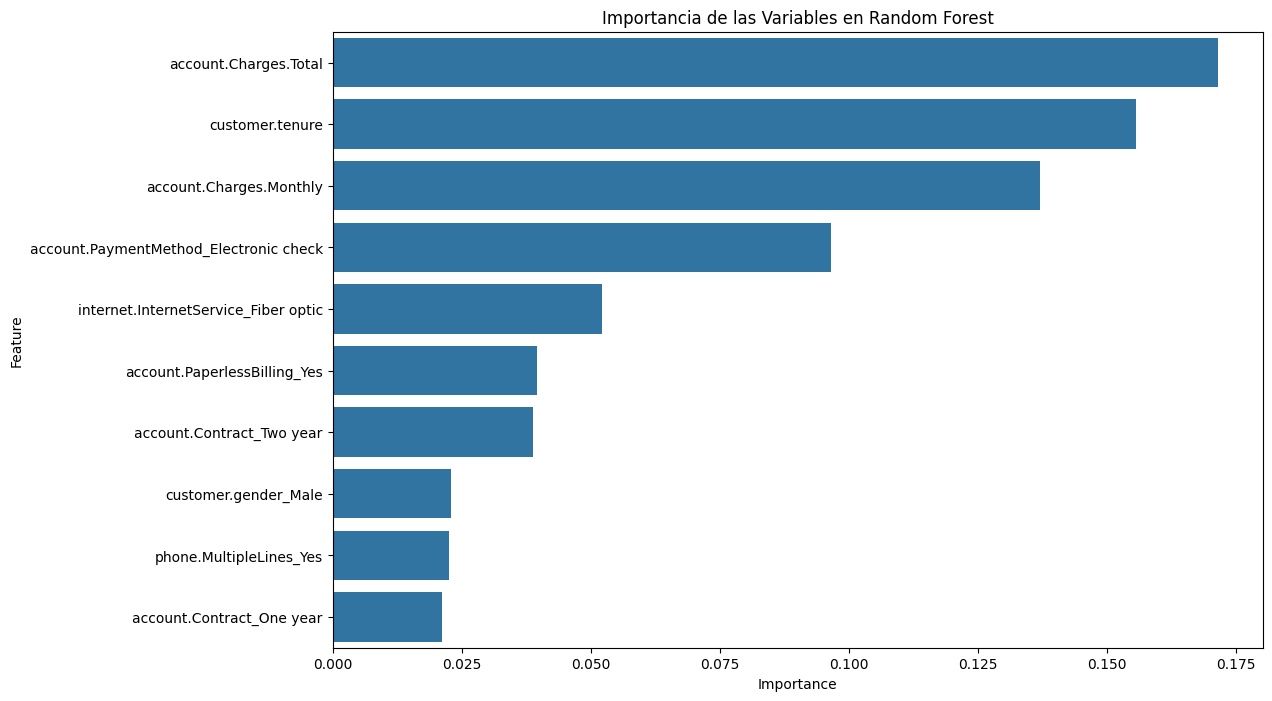

In [23]:
# Obtener la importancia de las variables del modelo de Random Forest
importances = random_forest_model.feature_importances_
feature_names = X.columns

# Crear un DataFrame para visualizar la importancia
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Importancia de las Variables en Random Forest')
plt.show()    

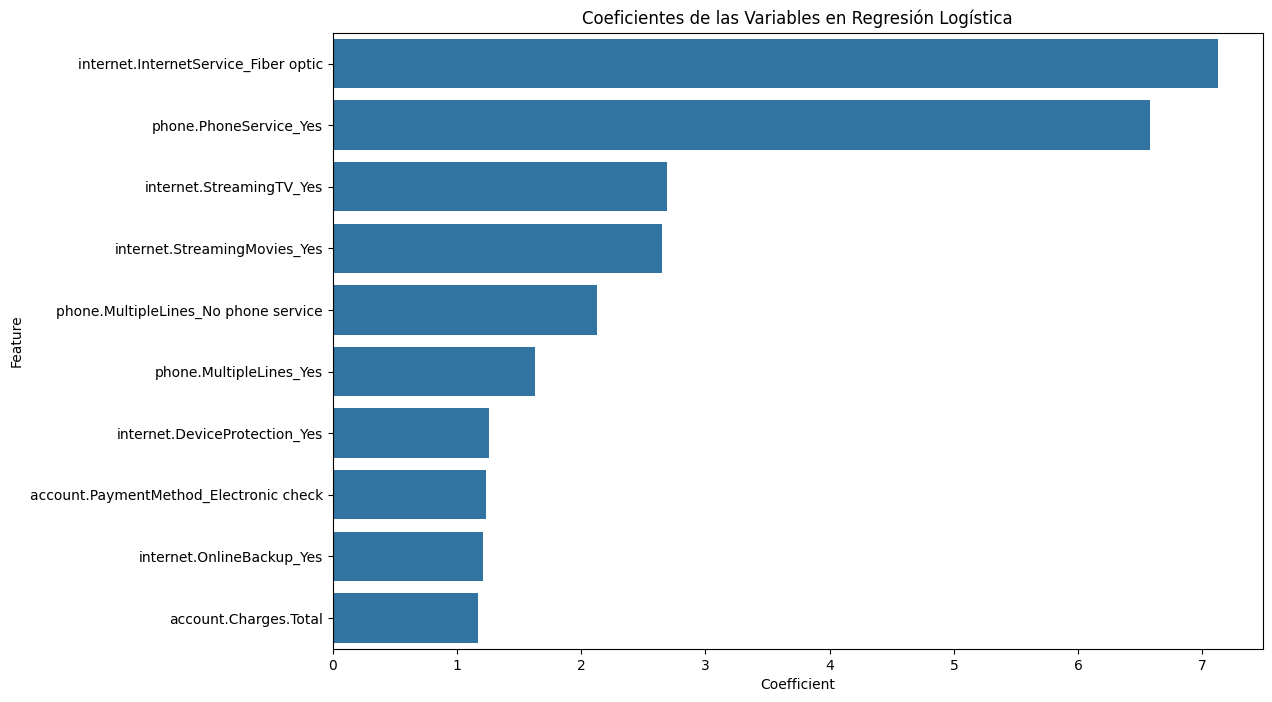

In [24]:
# Obtener los coeficientes del modelo de Regresión Logística
logistic_coefficients = logistic_model.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': logistic_coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Visualizar los coeficientes
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title('Coeficientes de las Variables en Regresión Logística')
plt.show()    

### **Conclusión**

En este informe, hemos realizado un análisis exhaustivo de los datos de cancelación de clientes, desde la carga y limpieza de datos hasta la creación y evaluación de modelos predictivos. A continuación, se presentan los puntos clave:

## Factores que influyen en la cancelación:
- La matriz de correlación mostró que ciertas variables, como el gasto total y el tiempo de contrato, tienen una correlación significativa con la cancelación.
- Los modelos de Regresión Logística y Random Forest proporcionaron diferentes perspectivas sobre la importancia de las variables.

## Desempeño de los Modelos:
- La Regresión Logística mostró una precisión y recall aceptables, pero puede haber estado subajustada.
- El modelo de Random Forest tuvo un mejor desempeño en términos de exactitud y F1-score, lo que sugiere que es más efectivo para este conjunto de datos.

## Overfitting y Underfitting:
- Se evaluó el riesgo de overfitting y underfitting en ambos modelos, sugiriendo ajustes según sea necesario.

## Estrategias de Retención:
- Basado en los factores identificados, se pueden implementar estrategias de retención, como mejorar el servicio al cliente, ofrecer descuentos a clientes con alto gasto, o ajustar los planes de contrato para reducir la cancelación.

Este análisis proporciona una base sólida para futuras investigaciones y estrategias de retención de clientes en la empresa de telecomunicaciones.